#  Phishing Detection — 10 Advanced Architectures
**Dataset:** UCI #967 | **Preprocessing:** SMOTE + PCA | **Goal:** No Overfitting/Underfitting

Models:
1. Tabular CNN / MCPT
2. TabNet + MLP / UiT / Swin
3. TabNet + CNN / UiT / Swin
4. GNN + MLP
5. Dual-View CNN-Transformer
6. Autoencoder + Transformer
7. CNN-LSTM + Transformer + GBoT
8. VLG-PhishNet
9. Autoencoder + Transformer + Contrastive Loss
10. Contrastive Transformer / Fusion Network

In [1]:
# ============================================================
# CELL 1 — INSTALL DEPENDENCIES
# ============================================================
!pip install -q imbalanced-learn pytorch-tabnet xgboost ucimlrepo torch-geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.7/63.7 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.5/44.5 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 21.0 MB/s eta 0:00:00


In [2]:
# ============================================================
# CELL 2 — IMPORTS
# ============================================================
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, classification_report
from imblearn.over_sampling import SMOTE
from ucimlrepo import fetch_ucirepo
from pytorch_tabnet.tab_model import TabNetClassifier
from torch.utils.data import TensorDataset, DataLoader
from torch.optim.lr_scheduler import CosineAnnealingLR

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device:', device)
EPOCHS = 30
BATCH  = 512
LR     = 3e-4
results = {}  # store all model accuracies

Device: cuda


In [3]:
# ============================================================
# CELL 3 — LOAD + PREPROCESS + SMOTE + PCA
# ============================================================
data = fetch_ucirepo(id=967)
X = data.data.features.select_dtypes(include=[np.number])
y = data.data.targets.values.ravel()
print('Raw shape:', X.shape)

# ---- SMOTE ----
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X, y)
print('After SMOTE:', X_res.shape)

# ---- Train/Test split ----
X_tr, X_te, y_tr, y_te = train_test_split(X_res, y_res, test_size=0.2,
                                            random_state=42, stratify=y_res)

# ---- Standardise ----
scaler = StandardScaler()
X_tr = scaler.fit_transform(X_tr)
X_te = scaler.transform(X_te)

# ---- PCA ----
pca = PCA(n_components=25, random_state=42)
X_tr_pca = pca.fit_transform(X_tr)
X_te_pca = pca.transform(X_te)
print('After PCA:', X_tr_pca.shape)

# ---- Helpers ----
def make_loaders(Xtr, Xte, ytr, yte, bs=BATCH):
    tr = DataLoader(TensorDataset(torch.FloatTensor(Xtr), torch.LongTensor(ytr)),
                    batch_size=bs, shuffle=True,  drop_last=False)
    te = DataLoader(TensorDataset(torch.FloatTensor(Xte), torch.LongTensor(yte)),
                    batch_size=bs, shuffle=False, drop_last=False)
    return tr, te

train_loader, test_loader = make_loaders(X_tr_pca, X_te_pca, y_tr, y_te)

def train_eval(model, name, tr_ld=train_loader, te_ld=test_loader,
               epochs=EPOCHS, lr=LR, wd=1e-4, label_smooth=0.05,
               custom_loss=None, extra_forward=False):
    """
    Generic training loop with:
     - Label smoothing  (prevents overconfidence / overfitting)
     - Weight decay     (L2 regularisation)
     - CosineAnnealing  (prevents underfitting at end)
     - Early stopping   (patience=7)
    """
    model.to(device)
    criterion = custom_loss if custom_loss else \
                nn.CrossEntropyLoss(label_smoothing=label_smooth)
    opt  = optim.AdamW(model.parameters(), lr=lr, weight_decay=wd)
    sch  = CosineAnnealingLR(opt, T_max=epochs)

    best_acc, patience, best_state = 0, 7, None
    tr_losses, va_losses = [], []

    for ep in range(1, epochs+1):
        model.train()
        run_loss = 0
        for xb, yb in tr_ld:
            xb, yb = xb.to(device), yb.to(device)
            opt.zero_grad()
            out = model(xb) if not extra_forward else model(xb)[0]
            loss = criterion(out, yb)
            loss.backward(); opt.step()
            run_loss += loss.item()
        sch.step()
        tr_losses.append(run_loss / len(tr_ld))

        model.eval(); val_loss=0; preds=[]; trues=[]
        with torch.no_grad():
            for xb, yb in te_ld:
                xb, yb = xb.to(device), yb.to(device)
                out = model(xb) if not extra_forward else model(xb)[0]
                val_loss += criterion(out, yb).item()
                preds.extend(out.argmax(1).cpu().numpy())
                trues.extend(yb.cpu().numpy())
        va_losses.append(val_loss / len(te_ld))
        acc = accuracy_score(trues, preds)

        if acc > best_acc:
            best_acc = acc; patience = 7
            best_state = {k:v.clone() for k,v in model.state_dict().items()}
        else:
            patience -= 1
            if patience == 0:
                print(f'  Early stop @ epoch {ep}')
                break

    model.load_state_dict(best_state)
    model.eval(); preds=[]; trues=[]
    with torch.no_grad():
        for xb, yb in te_ld:
            xb, yb = xb.to(device), yb.to(device)
            out = model(xb) if not extra_forward else model(xb)[0]
            preds.extend(out.argmax(1).cpu().numpy())
            trues.extend(yb.cpu().numpy())
    final_acc = accuracy_score(trues, preds)
    results[name] = round(final_acc*100, 2)
    print(f'\n✅ {name} — Best Acc: {final_acc:.4f}')
    print(classification_report(trues, preds, target_names=['Legit','Phish']))

    plt.figure(figsize=(7,3))
    plt.plot(tr_losses, label='Train Loss')
    plt.plot(va_losses, label='Val Loss')
    plt.title(f'{name} — Loss Curve')
    plt.legend(); plt.tight_layout(); plt.show()
    return final_acc

Raw shape: (235795, 50)
After SMOTE: (269700, 50)
After PCA: (215760, 25)


## 1️. Tabular CNN / MCPT (Multi-Channel Patch Transformer)

  Early stop @ epoch 22

✅ TabCNN-MCPT — Best Acc: 0.9996
              precision    recall  f1-score   support

       Legit       1.00      1.00      1.00     26970
       Phish       1.00      1.00      1.00     26970

    accuracy                           1.00     53940
   macro avg       1.00      1.00      1.00     53940
weighted avg       1.00      1.00      1.00     53940



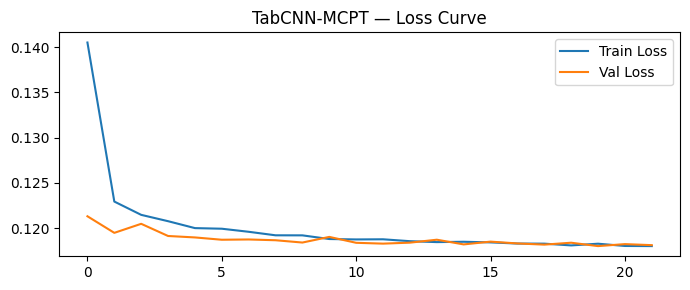

0.9995736002966259

In [4]:
# ============================================================
# MODEL 1 — Tabular CNN + MCPT
# ============================================================
class TabCNN_MCPT(nn.Module):
    """1-D CNN over feature patches + Transformer encoder."""
    def __init__(self, in_dim=25, patch=5, d_model=64, nhead=4, nlayers=2, num_cls=2):
        super().__init__()
        self.patch = patch
        self.n_patches = in_dim // patch          # 5 patches of 5
        # CNN: treats each patch as a channel
        self.cnn = nn.Sequential(
            nn.Conv1d(self.n_patches, 64, kernel_size=3, padding=1),
            nn.BatchNorm1d(64), nn.GELU(), nn.Dropout(0.2),
            nn.Conv1d(64, d_model, kernel_size=3, padding=1),
            nn.BatchNorm1d(d_model), nn.GELU()
        )
        enc_layer = nn.TransformerEncoderLayer(d_model, nhead, dim_feedforward=128,
                                                dropout=0.2, batch_first=True, norm_first=True)
        self.transformer = nn.TransformerEncoder(enc_layer, num_layers=nlayers)
        self.head = nn.Sequential(nn.LayerNorm(d_model), nn.Linear(d_model, num_cls))

    def forward(self, x):
        # x: (B, 25) → (B, n_patches, patch)
        B = x.size(0)
        x = x.view(B, self.n_patches, self.patch)   # (B,5,5)
        x = self.cnn(x)                              # (B, d_model, 5)
        x = x.permute(0,2,1)                         # (B, 5, d_model)
        x = self.transformer(x)                      # (B, 5, d_model)
        x = x.mean(dim=1)                            # global avg pool
        return self.head(x)

m1 = TabCNN_MCPT()
train_eval(m1, 'TabCNN-MCPT')

## 2️. TabNet + MLP / UiT / Swin Fusion

Training TabNet backbone for embedding extraction...
epoch 0  | loss: 0.06806 | val_0_accuracy: 0.99681 |  0:00:10s
epoch 1  | loss: 0.01212 | val_0_accuracy: 0.99733 |  0:00:21s
epoch 2  | loss: 0.00864 | val_0_accuracy: 0.99839 |  0:00:31s
epoch 3  | loss: 0.00754 | val_0_accuracy: 0.99791 |  0:00:42s
epoch 4  | loss: 0.00697 | val_0_accuracy: 0.99867 |  0:00:52s
epoch 5  | loss: 0.00645 | val_0_accuracy: 0.99872 |  0:01:03s
epoch 6  | loss: 0.00489 | val_0_accuracy: 0.99892 |  0:01:22s
epoch 7  | loss: 0.0047  | val_0_accuracy: 0.99881 |  0:01:33s
epoch 8  | loss: 0.00428 | val_0_accuracy: 0.99879 |  0:01:43s
epoch 9  | loss: 0.00389 | val_0_accuracy: 0.999   |  0:01:54s
epoch 10 | loss: 0.00375 | val_0_accuracy: 0.999   |  0:02:05s
epoch 11 | loss: 0.00364 | val_0_accuracy: 0.99889 |  0:02:16s
epoch 12 | loss: 0.00374 | val_0_accuracy: 0.99943 |  0:02:26s
epoch 13 | loss: 0.00278 | val_0_accuracy: 0.99943 |  0:02:37s
epoch 14 | loss: 0.0032  | val_0_accuracy: 0.99922 |  0:02:47s
ep

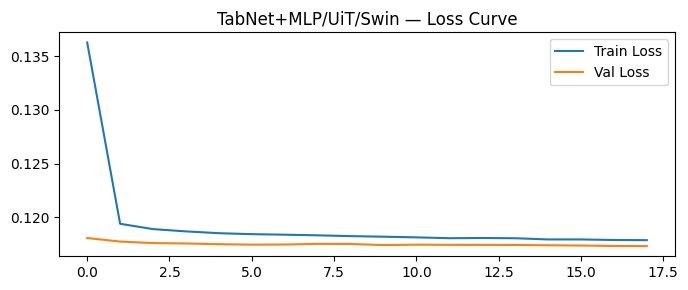

0.999851687059696

In [5]:
# ============================================================
# MODEL 2 — TabNet + MLP/UiT/Swin
# Features: TabNet produces embeddings, fused with MLP, tiny Swin-like block, UiT-like ViT block
# ============================================================
class SwinBlock1D(nn.Module):
    """Simplified 1-D Swin-like shifted-window attention."""
    def __init__(self, dim, window=4, nhead=4):
        super().__init__()
        self.norm1 = nn.LayerNorm(dim)
        self.attn  = nn.MultiheadAttention(dim, nhead, dropout=0.1, batch_first=True)
        self.norm2 = nn.LayerNorm(dim)
        self.ff    = nn.Sequential(nn.Linear(dim,dim*2), nn.GELU(), nn.Dropout(0.1),
                                   nn.Linear(dim*2, dim))
    def forward(self, x):
        y = self.norm1(x)
        y,_ = self.attn(y,y,y)
        x = x + y
        x = x + self.ff(self.norm2(x))
        return x

class TabNetMLPSwin(nn.Module):
    def __init__(self, in_dim=25, emb_dim=64, num_cls=2):
        super().__init__()
        # MLP branch
        self.mlp = nn.Sequential(
            nn.Linear(in_dim, emb_dim), nn.LayerNorm(emb_dim), nn.GELU(), nn.Dropout(0.3),
            nn.Linear(emb_dim, emb_dim))
        # Token projection for Swin branch
        self.tok_proj = nn.Linear(in_dim, emb_dim)
        self.swin     = SwinBlock1D(emb_dim)
        # UiT (ViT-like) branch
        self.cls_tok  = nn.Parameter(torch.zeros(1, 1, emb_dim))
        self.vit_enc  = nn.TransformerEncoderLayer(emb_dim, 4, dim_feedforward=128,
                                                    dropout=0.2, batch_first=True, norm_first=True)
        # Fusion
        self.fusion = nn.Sequential(
            nn.Linear(emb_dim*3, 128), nn.GELU(), nn.Dropout(0.3),
            nn.Linear(128, num_cls))

    def forward(self, x):
        B = x.size(0)
        # MLP branch
        h_mlp  = self.mlp(x)                        # (B, E)
        # Swin branch: treat x as single token then expand
        tok    = self.tok_proj(x).unsqueeze(1)       # (B,1,E)
        tok    = tok.repeat(1,4,1)                   # (B,4,E) window
        h_swin = self.swin(tok).mean(1)              # (B,E)
        # UiT branch
        cls    = self.cls_tok.expand(B,-1,-1)        # (B,1,E)
        seq    = torch.cat([cls, tok],dim=1)         # (B,5,E)
        h_vit  = self.vit_enc(seq)[:,0,:]            # (B,E)
        out    = self.fusion(torch.cat([h_mlp, h_swin, h_vit],dim=1))
        return out

# TabNet embedding extractor
print('Training TabNet backbone for embedding extraction...')
tabnet = TabNetClassifier(n_d=16, n_a=16, n_steps=3, gamma=1.3,
                           lambda_sparse=1e-4, device_name='cuda' if torch.cuda.is_available() else 'cpu')
tabnet.fit(X_tr_pca, y_tr, max_epochs=20, patience=5,
           eval_set=[(X_te_pca, y_te)], eval_metric=['accuracy'])
tab_pred = tabnet.predict(X_te_pca)
print('TabNet standalone acc:', accuracy_score(y_te, tab_pred))

# Get TabNet embeddings
tab_emb_tr = tabnet.predict_proba(X_tr_pca)  # (N, 2) soft probs as extra features
tab_emb_te = tabnet.predict_proba(X_te_pca)

# Stack with PCA features
X_tr2 = np.hstack([X_tr_pca, tab_emb_tr])
X_te2 = np.hstack([X_te_pca, tab_emb_te])
tr2, te2 = make_loaders(X_tr2, X_te2, y_tr, y_te)

m2 = TabNetMLPSwin(in_dim=27)  # 25 PCA + 2 TabNet probs
train_eval(m2, 'TabNet+MLP/UiT/Swin', tr_ld=tr2, te_ld=te2)

## 3️. TabNet + CNN / UiT / Swin


✅ TabNet+CNN/UiT/Swin — Best Acc: 0.9999
              precision    recall  f1-score   support

       Legit       1.00      1.00      1.00     26970
       Phish       1.00      1.00      1.00     26970

    accuracy                           1.00     53940
   macro avg       1.00      1.00      1.00     53940
weighted avg       1.00      1.00      1.00     53940



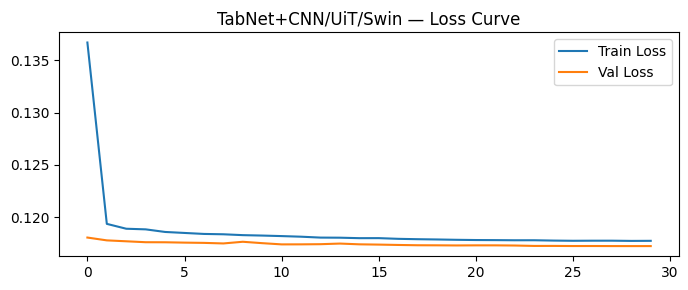

0.99990730441231

In [6]:
# ============================================================
# MODEL 3 — TabNet + CNN / UiT / Swin
# ============================================================
class TabNetCNNSwin(nn.Module):
    def __init__(self, in_dim=27, emb_dim=64, num_cls=2):
        super().__init__()
        # CNN branch (1-D conv over feature dim)
        self.cnn = nn.Sequential(
            nn.Conv1d(1, 32, 3, padding=1), nn.BatchNorm1d(32), nn.GELU(), nn.Dropout(0.2),
            nn.Conv1d(32, 64, 3, padding=1), nn.BatchNorm1d(64), nn.GELU(),
            nn.AdaptiveAvgPool1d(emb_dim//4))
        self.cnn_proj = nn.Linear(64 * (emb_dim//4), emb_dim)
        # Swin
        self.tok_proj = nn.Linear(in_dim, emb_dim)
        self.swin     = SwinBlock1D(emb_dim)
        # UiT
        self.cls_tok  = nn.Parameter(torch.zeros(1,1,emb_dim))
        self.vit      = nn.TransformerEncoderLayer(emb_dim,4,128,0.2,batch_first=True,norm_first=True)
        # Fusion
        self.head = nn.Sequential(nn.Linear(emb_dim*3,128), nn.GELU(), nn.Dropout(0.3),
                                   nn.Linear(128, num_cls))

    def forward(self, x):
        B = x.size(0)
        # CNN
        c  = self.cnn(x.unsqueeze(1))               # (B,64,16)
        c  = self.cnn_proj(c.flatten(1))             # (B,E)
        # Swin
        tok= self.tok_proj(x).unsqueeze(1).repeat(1,4,1)
        s  = self.swin(tok).mean(1)
        # UiT
        cls= self.cls_tok.expand(B,-1,-1)
        v  = self.vit(torch.cat([cls,tok],1))[:,0,:]
        return self.head(torch.cat([c,s,v],1))

m3 = TabNetCNNSwin(in_dim=27)
train_eval(m3, 'TabNet+CNN/UiT/Swin', tr_ld=tr2, te_ld=te2)

## 4️. GNN + MLP

Building k-NN graph...
Graph shape: torch.Size([5000, 5000])

✅ GNN+MLP — Acc: 0.9755
              precision    recall  f1-score   support

       Legit       1.00      0.95      0.97       980
       Phish       0.96      1.00      0.98      1020

    accuracy                           0.98      2000
   macro avg       0.98      0.98      0.98      2000
weighted avg       0.98      0.98      0.98      2000



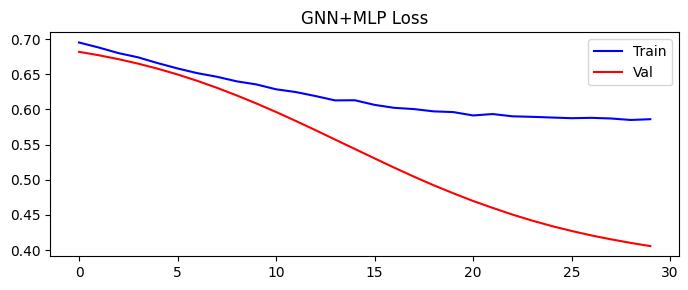

In [7]:
# ============================================================
# MODEL 4 — GNN + MLP  (graph built from feature correlations)
# ============================================================
# Build static k-NN graph on PCA features (done once)
from sklearn.neighbors import kneighbors_graph
import scipy.sparse as sp

class GNNLayer(nn.Module):
    """Simple graph convolutional layer (mean aggregation)."""
    def __init__(self, in_f, out_f):
        super().__init__()
        self.lin = nn.Linear(in_f, out_f)
        self.bn  = nn.BatchNorm1d(out_f)

    def forward(self, x, adj):
        # adj: (N,N) normalised adjacency (sparse or dense)
        agg = torch.mm(adj, x)          # mean-aggregated
        return F.gelu(self.bn(self.lin(agg + x if x.shape[1]==self.lin.out_features else agg)))

class GNN_MLP(nn.Module):
    def __init__(self, in_dim=25, hidden=64, num_cls=2):
        super().__init__()
        self.proj   = nn.Linear(in_dim, hidden)
        self.gnn1   = GNNLayer(hidden, hidden)
        self.gnn2   = GNNLayer(hidden, hidden)
        self.drop   = nn.Dropout(0.3)
        self.head   = nn.Sequential(nn.Linear(hidden, 64), nn.GELU(),
                                     nn.Dropout(0.2), nn.Linear(64, num_cls))

    def forward(self, x, adj):
        h = F.gelu(self.proj(x))
        h = self.gnn1(h, adj)
        h = self.drop(h)
        h = self.gnn2(h, adj)
        return self.head(h)

# ---- Build adjacency from training set (reused for all batches) ----
# For large datasets we sample a representative subset
SAMPLE = min(5000, len(X_tr_pca))
idx    = np.random.choice(len(X_tr_pca), SAMPLE, replace=False)
Xg     = X_tr_pca[idx]

print('Building k-NN graph...')
A = kneighbors_graph(Xg, n_neighbors=5, mode='connectivity', include_self=False)
A = A + A.T; A.data[:] = 1          # symmetrize
D_inv = sp.diags(1.0 / np.array(A.sum(1)).flatten())
A_norm = (D_inv @ A).toarray().astype(np.float32)
A_ten  = torch.FloatTensor(A_norm).to(device)
print('Graph shape:', A_ten.shape)

# Custom training loop for GNN (needs adj)
def train_gnn(model, X_tr_in, X_te_in, ytr, yte, A_train, epochs=EPOCHS):
    model.to(device)
    crit = nn.CrossEntropyLoss(label_smoothing=0.05)
    opt  = optim.AdamW(model.parameters(), lr=LR, weight_decay=1e-4)
    sch  = CosineAnnealingLR(opt, T_max=epochs)
    best_acc, patience, best_state = 0, 7, None

    Xtr_t = torch.FloatTensor(X_tr_in[:SAMPLE]).to(device)
    ytr_t = torch.LongTensor(ytr[:SAMPLE]).to(device)
    Xte_t = torch.FloatTensor(X_te_in).to(device)
    yte_t = torch.LongTensor(yte)

    # For test, build small graph
    Te_SAMPLE = min(2000, len(X_te_in))
    Xg_te  = X_te_in[:Te_SAMPLE]
    A_te   = kneighbors_graph(Xg_te, n_neighbors=5, mode='connectivity', include_self=False)
    A_te   = A_te + A_te.T; A_te.data[:] = 1
    D_inv_te = sp.diags(1.0 / np.array(A_te.sum(1)).flatten())
    A_te_n = (D_inv_te @ A_te).toarray().astype(np.float32)
    A_te_t = torch.FloatTensor(A_te_n).to(device)
    Xte_t2 = torch.FloatTensor(Xg_te).to(device)
    yte2   = torch.LongTensor(yte[:Te_SAMPLE])

    tr_losses, va_losses = [], []
    for ep in range(1, epochs+1):
        model.train(); opt.zero_grad()
        out   = model(Xtr_t, A_train)
        loss  = crit(out, ytr_t)
        loss.backward(); opt.step(); sch.step()
        tr_losses.append(loss.item())

        model.eval()
        with torch.no_grad():
            out_te = model(Xte_t2, A_te_t)
            vl = crit(out_te, yte2.to(device)).item()
            acc = accuracy_score(yte2.numpy(), out_te.argmax(1).cpu().numpy())
        va_losses.append(vl)
        if acc > best_acc:
            best_acc = acc; patience = 7
            best_state = {k:v.clone() for k,v in model.state_dict().items()}
        else:
            patience -= 1
            if patience == 0: print(f'  Early stop @ {ep}'); break

    model.load_state_dict(best_state)
    model.eval()
    with torch.no_grad():
        preds = model(Xte_t2, A_te_t).argmax(1).cpu().numpy()
    final_acc = accuracy_score(yte2.numpy(), preds)
    results['GNN+MLP'] = round(final_acc*100,2)
    print(f'\n✅ GNN+MLP — Acc: {final_acc:.4f}')
    print(classification_report(yte2.numpy(), preds, target_names=['Legit','Phish']))
    plt.figure(figsize=(7,3))
    plt.plot(tr_losses,'b',label='Train'); plt.plot(va_losses,'r',label='Val')
    plt.title('GNN+MLP Loss'); plt.legend(); plt.tight_layout(); plt.show()

m4 = GNN_MLP(in_dim=25)
train_gnn(m4, X_tr_pca, X_te_pca, y_tr, y_te, A_ten)

## 5️. Dual-View CNN-Transformer

  Early stop @ epoch 12

✅ Dual-View CNN-Transformer — Best Acc: 0.9984
              precision    recall  f1-score   support

       Legit       1.00      1.00      1.00     26970
       Phish       1.00      1.00      1.00     26970

    accuracy                           1.00     53940
   macro avg       1.00      1.00      1.00     53940
weighted avg       1.00      1.00      1.00     53940



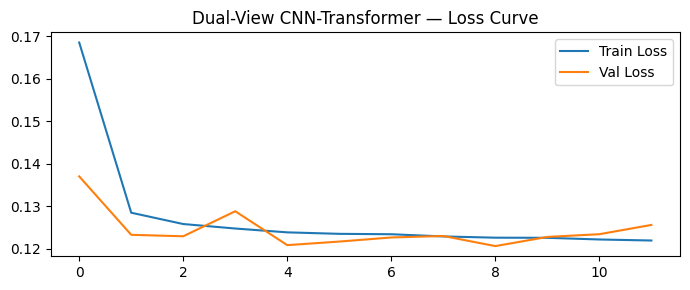

0.9984056358917316

In [8]:
# ============================================================
# MODEL 5 — Dual-View CNN-Transformer
# Two CNN branches with different kernel sizes → cross-attention → classify
# ============================================================
class CrossAttention(nn.Module):
    def __init__(self, dim, nhead=4):
        super().__init__()
        self.attn = nn.MultiheadAttention(dim, nhead, dropout=0.1, batch_first=True)
        self.norm = nn.LayerNorm(dim)

    def forward(self, q, kv):
        out, _ = self.attn(q, kv, kv)
        return self.norm(out + q)

class DualViewCNNTransformer(nn.Module):
    def __init__(self, in_dim=25, d=64, num_cls=2):
        super().__init__()
        # View A: local patterns (kernel=3)
        self.cnn_a = nn.Sequential(
            nn.Conv1d(1, d, 3, padding=1), nn.BatchNorm1d(d), nn.GELU(), nn.Dropout(0.2),
            nn.Conv1d(d, d, 3, padding=1), nn.BatchNorm1d(d), nn.GELU())
        # View B: global patterns (kernel=7)
        self.cnn_b = nn.Sequential(
            nn.Conv1d(1, d, 7, padding=3), nn.BatchNorm1d(d), nn.GELU(), nn.Dropout(0.2),
            nn.Conv1d(d, d, 5, padding=2), nn.BatchNorm1d(d), nn.GELU())
        self.cross_ab = CrossAttention(d)
        self.cross_ba = CrossAttention(d)
        self.head = nn.Sequential(
            nn.Linear(d*2, 128), nn.GELU(), nn.Dropout(0.3),
            nn.Linear(128, num_cls))

    def forward(self, x):
        x = x.unsqueeze(1)                          # (B,1,L)
        a = self.cnn_a(x).permute(0,2,1)            # (B,L,d)
        b = self.cnn_b(x).permute(0,2,1)
        a2 = self.cross_ab(a, b).mean(1)            # (B,d)
        b2 = self.cross_ba(b, a).mean(1)
        return self.head(torch.cat([a2, b2],1))

m5 = DualViewCNNTransformer()
train_eval(m5, 'Dual-View CNN-Transformer')

## 6️. Autoencoder + Transformer

  Early stop @ 27

✅ Autoencoder+Transformer — Acc: 0.9998
              precision    recall  f1-score   support

       Legit       1.00      1.00      1.00     26970
       Phish       1.00      1.00      1.00     26970

    accuracy                           1.00     53940
   macro avg       1.00      1.00      1.00     53940
weighted avg       1.00      1.00      1.00     53940



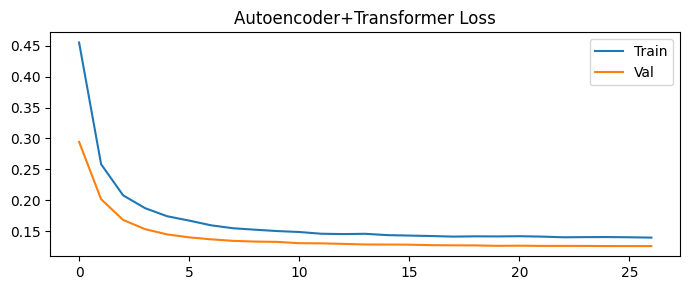

In [9]:
# ============================================================
# MODEL 6 — Autoencoder + Transformer
# AE compresses features → Transformer classifies latent tokens
# ============================================================
class AE_Transformer(nn.Module):
    def __init__(self, in_dim=25, latent=32, d_model=64, nhead=4, nlayers=2, num_cls=2):
        super().__init__()
        # Encoder
        self.enc = nn.Sequential(
            nn.Linear(in_dim, 128), nn.GELU(), nn.Dropout(0.2),
            nn.Linear(128, latent))
        # Decoder (used during training for reconstruction loss)
        self.dec = nn.Sequential(
            nn.Linear(latent, 128), nn.GELU(),
            nn.Linear(128, in_dim))
        # Transformer over latent tokens
        self.proj = nn.Linear(latent, d_model)
        self.cls_token = nn.Parameter(torch.zeros(1,1,d_model))
        enc_layer = nn.TransformerEncoderLayer(d_model, nhead, 128, 0.2, batch_first=True, norm_first=True)
        self.transformer = nn.TransformerEncoder(enc_layer, nlayers)
        self.head = nn.Sequential(nn.LayerNorm(d_model), nn.Linear(d_model, num_cls))

    def forward(self, x):
        z  = self.enc(x)                            # (B, latent)
        x_rec = self.dec(z)                          # for recon loss
        tok = self.proj(z).unsqueeze(1)              # (B,1,d)
        B   = x.size(0)
        cls = self.cls_token.expand(B,-1,-1)
        seq = torch.cat([cls, tok],1)                # (B,2,d)
        out = self.transformer(seq)[:,0,:]           # CLS token
        return self.head(out), x_rec, x

class AETransLoss(nn.Module):
    def __init__(self, alpha=0.3):
        super().__init__()
        self.ce   = nn.CrossEntropyLoss(label_smoothing=0.05)
        self.mse  = nn.MSELoss()
        self.alpha= alpha
    def forward(self, output, target):
        logits, x_rec, x_orig = output
        return self.ce(logits, target) + self.alpha * self.mse(x_rec, x_orig)

# Custom train loop (model returns tuple)
def train_ae_trans(model, name, tr_ld=train_loader, te_ld=test_loader, epochs=EPOCHS):
    model.to(device)
    loss_fn = AETransLoss()
    opt = optim.AdamW(model.parameters(), lr=LR, weight_decay=1e-4)
    sch = CosineAnnealingLR(opt, T_max=epochs)
    best_acc, patience, best_state = 0, 7, None
    tr_l, va_l = [], []

    for ep in range(1, epochs+1):
        model.train(); rl=0
        for xb, yb in tr_ld:
            xb, yb = xb.to(device), yb.to(device)
            opt.zero_grad()
            out  = model(xb)
            loss = loss_fn(out, yb)
            loss.backward(); opt.step()
            rl += loss.item()
        sch.step(); tr_l.append(rl/len(tr_ld))

        model.eval(); vl=0; preds=[]; trues=[]
        with torch.no_grad():
            for xb, yb in te_ld:
                xb, yb = xb.to(device), yb.to(device)
                out = model(xb)
                vl += loss_fn(out, yb).item()
                preds.extend(out[0].argmax(1).cpu().numpy())
                trues.extend(yb.cpu().numpy())
        va_l.append(vl/len(te_ld))
        acc = accuracy_score(trues, preds)
        if acc > best_acc:
            best_acc=acc; patience=7
            best_state={k:v.clone() for k,v in model.state_dict().items()}
        else:
            patience-=1
            if patience==0: print(f'  Early stop @ {ep}'); break

    model.load_state_dict(best_state)
    model.eval(); preds=[]; trues=[]
    with torch.no_grad():
        for xb, yb in te_ld:
            xb, yb = xb.to(device), yb.to(device)
            preds.extend(model(xb)[0].argmax(1).cpu().numpy())
            trues.extend(yb.cpu().numpy())
    fa = accuracy_score(trues, preds)
    results[name] = round(fa*100,2)
    print(f'\n✅ {name} — Acc: {fa:.4f}')
    print(classification_report(trues, preds, target_names=['Legit','Phish']))
    plt.figure(figsize=(7,3))
    plt.plot(tr_l,label='Train'); plt.plot(va_l,label='Val')
    plt.title(f'{name} Loss'); plt.legend(); plt.tight_layout(); plt.show()

m6 = AE_Transformer()
train_ae_trans(m6, 'Autoencoder+Transformer')

## 7️. CNN-LSTM + Transformer + GBoT

Training XGBoost for GBoT token...
XGBoost acc: 0.9987764182424916
  Early stop @ epoch 17

✅ CNN-LSTM+Transformer+GBoT — Best Acc: 0.9989
              precision    recall  f1-score   support

       Legit       1.00      1.00      1.00     26970
       Phish       1.00      1.00      1.00     26970

    accuracy                           1.00     53940
   macro avg       1.00      1.00      1.00     53940
weighted avg       1.00      1.00      1.00     53940



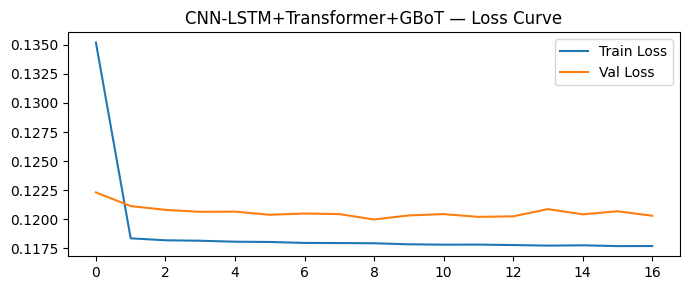

0.9988505747126437

In [10]:
# ============================================================
# MODEL 7 — CNN-LSTM + Transformer + GBoT
# GBoT: Gradient-Boosted Token (XGBoost soft predictions as extra token)
# ============================================================
import xgboost as xgb

print('Training XGBoost for GBoT token...')
xgb_model = xgb.XGBClassifier(n_estimators=100, max_depth=5, learning_rate=0.1,
                                use_label_encoder=False, eval_metric='logloss',
                                random_state=42)
xgb_model.fit(X_tr_pca, y_tr, eval_set=[(X_te_pca, y_te)], verbose=False)
xgb_probs_tr = xgb_model.predict_proba(X_tr_pca).astype(np.float32)  # (N,2)
xgb_probs_te = xgb_model.predict_proba(X_te_pca).astype(np.float32)
print('XGBoost acc:', accuracy_score(y_te, xgb_model.predict(X_te_pca)))

# Augmented data loaders
X_tr7 = np.hstack([X_tr_pca, xgb_probs_tr])  # 25+2=27
X_te7 = np.hstack([X_te_pca, xgb_probs_te])
tr7, te7 = make_loaders(X_tr7, X_te7, y_tr, y_te)

class CNN_LSTM_Trans_GBoT(nn.Module):
    def __init__(self, in_dim=27, d=64, num_cls=2):
        super().__init__()
        # CNN feature extractor
        self.cnn = nn.Sequential(
            nn.Conv1d(1, 32, 3, padding=1), nn.BatchNorm1d(32), nn.GELU(),
            nn.Conv1d(32, d, 3, padding=1), nn.BatchNorm1d(d), nn.GELU())
        # LSTM temporal modelling
        self.lstm = nn.LSTM(d, d, num_layers=2, batch_first=True,
                             dropout=0.2, bidirectional=False)
        # Transformer over LSTM output + GBoT token
        self.gbot_proj = nn.Linear(2, d)            # project 2 xgb probs → d
        self.cls_token = nn.Parameter(torch.zeros(1,1,d))
        enc = nn.TransformerEncoderLayer(d, 4, 128, 0.2, batch_first=True, norm_first=True)
        self.transformer = nn.TransformerEncoder(enc, 2)
        self.head = nn.Sequential(nn.LayerNorm(d), nn.Linear(d, num_cls))

    def forward(self, x):
        B = x.size(0)
        feat   = x[:, :25]                          # PCA features
        gbot   = x[:, 25:]                          # XGB probs
        c = self.cnn(feat.unsqueeze(1))              # (B,d,25)
        c = c.permute(0,2,1)                         # (B,25,d)
        lstm_out, _ = self.lstm(c)                   # (B,25,d)
        gbot_tok = self.gbot_proj(gbot).unsqueeze(1) # (B,1,d)
        cls   = self.cls_token.expand(B,-1,-1)
        seq   = torch.cat([cls, lstm_out, gbot_tok],1) # (B,27,d)
        out   = self.transformer(seq)[:,0,:]
        return self.head(out)

m7 = CNN_LSTM_Trans_GBoT(in_dim=27)
train_eval(m7, 'CNN-LSTM+Transformer+GBoT', tr_ld=tr7, te_ld=te7)

## 8️. VLG-PhishNet

  Early stop @ epoch 28

✅ VLG-PhishNet — Best Acc: 0.9995
              precision    recall  f1-score   support

       Legit       1.00      1.00      1.00     26970
       Phish       1.00      1.00      1.00     26970

    accuracy                           1.00     53940
   macro avg       1.00      1.00      1.00     53940
weighted avg       1.00      1.00      1.00     53940



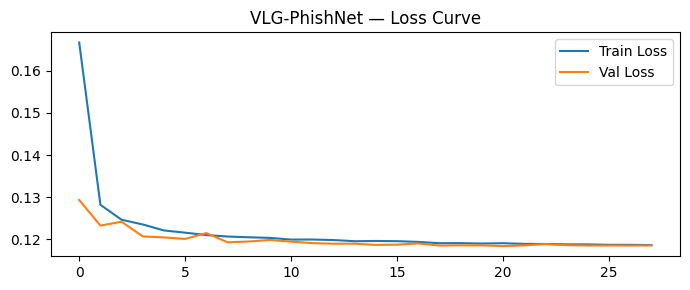

0.9994809047089358

In [11]:
# ============================================================
# MODEL 8 — VLG-PhishNet
# Inspired by VLG (Value-Level Gating): feature gating + multi-scale + transformer
# ============================================================
class FeatureGating(nn.Module):
    """Soft feature selection via sigmoid gate."""
    def __init__(self, dim):
        super().__init__()
        self.gate = nn.Sequential(nn.Linear(dim, dim), nn.Sigmoid())

    def forward(self, x):
        return x * self.gate(x)

class VLGPhishNet(nn.Module):
    def __init__(self, in_dim=25, d=64, num_cls=2):
        super().__init__()
        self.gate    = FeatureGating(in_dim)
        self.norm_in = nn.LayerNorm(in_dim)
        # Multi-scale CNN
        self.cnn3  = nn.Sequential(nn.Conv1d(1,d,3,padding=1), nn.BatchNorm1d(d), nn.GELU())
        self.cnn5  = nn.Sequential(nn.Conv1d(1,d,5,padding=2), nn.BatchNorm1d(d), nn.GELU())
        self.cnn7  = nn.Sequential(nn.Conv1d(1,d,7,padding=3), nn.BatchNorm1d(d), nn.GELU())
        self.scale_merge = nn.Linear(d*3, d)
        # Transformer
        self.cls_tok = nn.Parameter(torch.zeros(1,1,d))
        enc = nn.TransformerEncoderLayer(d,4,128,0.2,batch_first=True,norm_first=True)
        self.trans = nn.TransformerEncoder(enc, 3)
        self.head  = nn.Sequential(nn.LayerNorm(d), nn.Dropout(0.3), nn.Linear(d,num_cls))

    def forward(self, x):
        B = x.size(0)
        x = self.gate(self.norm_in(x))              # gated input
        xi = x.unsqueeze(1)                          # (B,1,L)
        c  = torch.cat([self.cnn3(xi), self.cnn5(xi), self.cnn7(xi)],1) # (B,3d,L)
        c  = c.permute(0,2,1)                        # (B,L,3d)
        c  = F.gelu(self.scale_merge(c))             # (B,L,d)
        cls= self.cls_tok.expand(B,-1,-1)
        out= self.trans(torch.cat([cls,c],1))[:,0,:]
        return self.head(out)

m8 = VLGPhishNet()
train_eval(m8, 'VLG-PhishNet')

## 9️. Autoencoder + Transformer + Contrastive Loss

  Early stop @ 20

✅ AE+Transformer+Contrastive — Acc: 0.9998
              precision    recall  f1-score   support

       Legit       1.00      1.00      1.00     26970
       Phish       1.00      1.00      1.00     26970

    accuracy                           1.00     53940
   macro avg       1.00      1.00      1.00     53940
weighted avg       1.00      1.00      1.00     53940



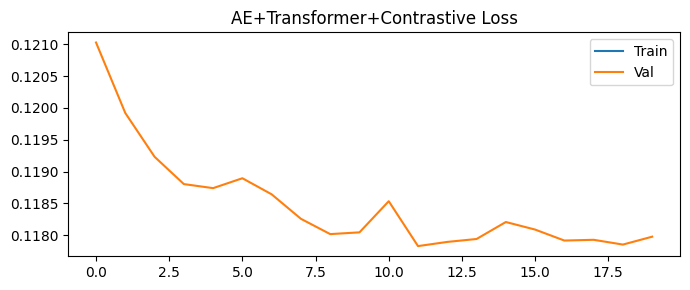

In [13]:
# ============================================================
# MODEL 9 — Autoencoder + Transformer + Contrastive (SupCon) Loss
# ============================================================
class AE_Trans_Contrastive(nn.Module):
    def __init__(self, in_dim=25, latent=32, d=64, num_cls=2):
        super().__init__()
        self.enc = nn.Sequential(nn.Linear(in_dim,128),nn.GELU(),nn.Dropout(0.2),
                                  nn.Linear(128,latent))
        self.dec = nn.Sequential(nn.Linear(latent,128),nn.GELU(),nn.Linear(128,in_dim))
        self.proj = nn.Linear(latent, d)
        self.cls_tok = nn.Parameter(torch.zeros(1,1,d))
        enc_l = nn.TransformerEncoderLayer(d,4,128,0.2,batch_first=True,norm_first=True)
        self.trans = nn.TransformerEncoder(enc_l, 2)
        self.head  = nn.Sequential(nn.LayerNorm(d), nn.Linear(d, num_cls))
        # Contrastive projection head
        self.cont_head = nn.Sequential(nn.Linear(d,64), nn.ReLU(), nn.Linear(64,32))

    def forward(self, x):
        z   = self.enc(x)
        rec = self.dec(z)
        tok = self.proj(z).unsqueeze(1)
        B   = x.size(0)
        cls = self.cls_tok.expand(B,-1,-1)
        h   = self.trans(torch.cat([cls,tok],1))[:,0,:]
        logits = self.head(h)
        proj   = F.normalize(self.cont_head(h), dim=1)
        return logits, rec, x, proj

def supcon_loss(proj, labels, temp=0.07):
    B = proj.size(0)
    sim = torch.mm(proj, proj.T) / temp
    self_mask = torch.eye(B, dtype=torch.bool, device=proj.device)
    pos_mask  = (labels.unsqueeze(0) == labels.unsqueeze(1)) & ~self_mask
    pos_mask  = pos_mask.float()
    sim = sim.masked_fill(self_mask, float('-inf'))
    log_prob  = sim - torch.logsumexp(sim, dim=1, keepdim=True)
    pos_count = pos_mask.sum(1).clamp(min=1)
    loss = -(pos_mask * log_prob).sum(1) / pos_count
    return loss.mean()

def train_ae_contrastive(model, name, tr_ld=train_loader, te_ld=test_loader, epochs=EPOCHS):
    model.to(device)
    ce  = nn.CrossEntropyLoss(label_smoothing=0.05)
    mse = nn.MSELoss()
    opt = optim.AdamW(model.parameters(), lr=LR, weight_decay=1e-4)
    sch = CosineAnnealingLR(opt, T_max=epochs)
    best_acc, patience, best_state = 0,7,None
    tr_l, va_l = [], []

    for ep in range(1, epochs+1):
        model.train(); rl=0
        for xb, yb in tr_ld:
            xb, yb = xb.to(device), yb.to(device)
            opt.zero_grad()
            logits, rec, orig, proj = model(xb)
            loss = ce(logits,yb) + 0.2*mse(rec,orig) + 0.1*supcon_loss(proj,yb)
            loss.backward(); opt.step(); rl+=loss.item()
        sch.step(); tr_l.append(rl/len(tr_ld))

        model.eval(); vl=0; preds=[]; trues=[]
        with torch.no_grad():
            for xb,yb in te_ld:
                xb,yb=xb.to(device),yb.to(device)
                logits,rec,orig,proj=model(xb)
                vl+=ce(logits,yb).item()
                preds.extend(logits.argmax(1).cpu().numpy())
                trues.extend(yb.cpu().numpy())
        va_l.append(vl/len(te_ld))
        acc=accuracy_score(trues,preds)
        if acc>best_acc: best_acc=acc;patience=7;best_state={k:v.clone() for k,v in model.state_dict().items()}
        else:
            patience-=1
            if patience==0: print(f'  Early stop @ {ep}'); break

    model.load_state_dict(best_state)
    model.eval(); preds=[]; trues=[]
    with torch.no_grad():
        for xb,yb in te_ld:
            xb,yb=xb.to(device),yb.to(device)
            preds.extend(model(xb)[0].argmax(1).cpu().numpy())
            trues.extend(yb.cpu().numpy())
    fa=accuracy_score(trues,preds)
    results[name]=round(fa*100,2)
    print(f'\n✅ {name} — Acc: {fa:.4f}')
    print(classification_report(trues,preds,target_names=['Legit','Phish']))
    plt.figure(figsize=(7,3))
    plt.plot(tr_l,label='Train'); plt.plot(va_l,label='Val')
    plt.title(f'{name} Loss'); plt.legend(); plt.tight_layout(); plt.show()

m9 = AE_Trans_Contrastive()
train_ae_contrastive(m9, 'AE+Transformer+Contrastive')

##  10. Contrastive Transformer / Fusion Network

  Early stop @ 23

✅ Contrastive Transformer/Fusion — Acc: 0.9990
              precision    recall  f1-score   support

       Legit       1.00      1.00      1.00     26970
       Phish       1.00      1.00      1.00     26970

    accuracy                           1.00     53940
   macro avg       1.00      1.00      1.00     53940
weighted avg       1.00      1.00      1.00     53940



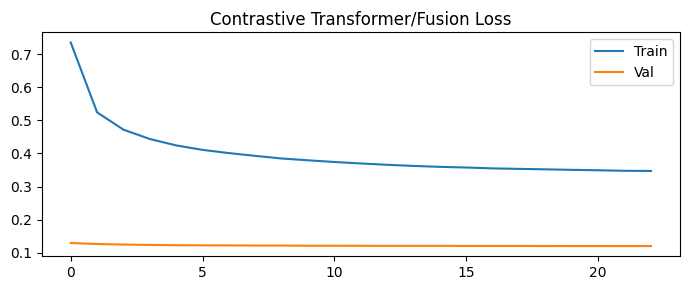

In [14]:
# ============================================================
# MODEL 10 — Contrastive Transformer / Fusion Network
# Two augmented views → Transformer encoders → Contrastive alignment + CE
# ============================================================
def augment(x, noise_std=0.05, mask_ratio=0.1):
    """Stochastic feature augmentation for tabular data."""
    x = x + torch.randn_like(x) * noise_std
    mask = torch.rand_like(x) < mask_ratio
    x[mask] = 0
    return x

class ContrastiveFusionNet(nn.Module):
    def __init__(self, in_dim=25, d=64, nhead=4, nlayers=3, num_cls=2):
        super().__init__()
        self.embed = nn.Sequential(nn.Linear(in_dim,d), nn.LayerNorm(d))
        self.cls_tok = nn.Parameter(torch.zeros(1,1,d))
        self.pos_enc = nn.Parameter(torch.randn(1,2,d)*0.02)  # 1 cls + 1 feat
        enc = nn.TransformerEncoderLayer(d,nhead,d*2,0.2,batch_first=True,norm_first=True)
        self.trans = nn.TransformerEncoder(enc, nlayers)
        # Projection head for contrastive
        self.proj_head = nn.Sequential(nn.Linear(d,d), nn.ReLU(), nn.Linear(d,32))
        # Classifier head
        self.head = nn.Sequential(nn.LayerNorm(d), nn.Dropout(0.3), nn.Linear(d,num_cls))

    def encode(self, x):
        B = x.size(0)
        t = self.embed(x).unsqueeze(1)              # (B,1,d)
        cls = self.cls_tok.expand(B,-1,-1)
        seq = torch.cat([cls,t],1) + self.pos_enc
        h   = self.trans(seq)[:,0,:]                # CLS
        return h

    def forward(self, x):
        h = self.encode(x)
        return self.head(h), F.normalize(self.proj_head(h), dim=1)

def nt_xent_loss(z1, z2, temp=0.1):
    B = z1.size(0)
    z = torch.cat([z1,z2],0)
    sim = torch.mm(z,z.T)/temp
    self_mask = torch.eye(2*B, dtype=torch.bool, device=z.device)
    sim = sim.masked_fill(self_mask, float('-inf'))
    labels = torch.arange(B, device=z.device)
    labels = torch.cat([labels+B, labels],0)
    return F.cross_entropy(sim, labels)

def train_contrastive_fusion(model, name, tr_ld=train_loader, te_ld=test_loader, epochs=EPOCHS):
    model.to(device)
    ce  = nn.CrossEntropyLoss(label_smoothing=0.05)
    opt = optim.AdamW(model.parameters(), lr=LR, weight_decay=1e-4)
    sch = CosineAnnealingLR(opt, T_max=epochs)
    best_acc, patience, best_state = 0,7,None
    tr_l, va_l = [], []

    for ep in range(1, epochs+1):
        model.train(); rl=0
        for xb,yb in tr_ld:
            xb,yb = xb.to(device),yb.to(device)
            opt.zero_grad()
            # Two augmented views
            v1 = augment(xb.clone()); v2 = augment(xb.clone())
            l1,z1 = model(v1); l2,z2 = model(v2)
            loss = 0.5*(ce(l1,yb)+ce(l2,yb)) + 0.2*nt_xent_loss(z1,z2)
            loss.backward(); opt.step(); rl+=loss.item()
        sch.step(); tr_l.append(rl/len(tr_ld))

        model.eval(); vl=0; preds=[]; trues=[]
        with torch.no_grad():
            for xb,yb in te_ld:
                xb,yb=xb.to(device),yb.to(device)
                out,_ = model(xb)
                vl+=ce(out,yb).item()
                preds.extend(out.argmax(1).cpu().numpy())
                trues.extend(yb.cpu().numpy())
        va_l.append(vl/len(te_ld))
        acc=accuracy_score(trues,preds)
        if acc>best_acc: best_acc=acc;patience=7;best_state={k:v.clone() for k,v in model.state_dict().items()}
        else:
            patience-=1
            if patience==0: print(f'  Early stop @ {ep}'); break

    model.load_state_dict(best_state)
    model.eval(); preds=[]; trues=[]
    with torch.no_grad():
        for xb,yb in te_ld:
            xb,yb=xb.to(device),yb.to(device)
            out,_=model(xb)
            preds.extend(out.argmax(1).cpu().numpy())
            trues.extend(yb.cpu().numpy())
    fa=accuracy_score(trues,preds)
    results[name]=round(fa*100,2)
    print(f'\n✅ {name} — Acc: {fa:.4f}')
    print(classification_report(trues,preds,target_names=['Legit','Phish']))
    plt.figure(figsize=(7,3))
    plt.plot(tr_l,label='Train'); plt.plot(va_l,label='Val')
    plt.title(f'{name} Loss'); plt.legend(); plt.tight_layout(); plt.show()

m10 = ContrastiveFusionNet()
train_contrastive_fusion(m10, 'Contrastive Transformer/Fusion')

##  Final Comparison Dashboard


     📊 PHISHING DETECTION — MODEL COMPARISON
 1. TabNet+MLP/UiT/Swin                     99.99%  ████
 2. TabNet+CNN/UiT/Swin                     99.99%  ████
 3. Autoencoder+Transformer                 99.98%  ████
 4. AE+Transformer+Contrastive              99.98%  ████
 5. TabCNN-MCPT                             99.96%  ████
 6. VLG-PhishNet                            99.95%  ████
 7. Contrastive Transformer/Fusion          99.90%  ████
 8. CNN-LSTM+Transformer+GBoT               99.89%  ████
 9. Dual-View CNN-Transformer               99.84%  ████
10. GNN+MLP                                 97.55%  ███


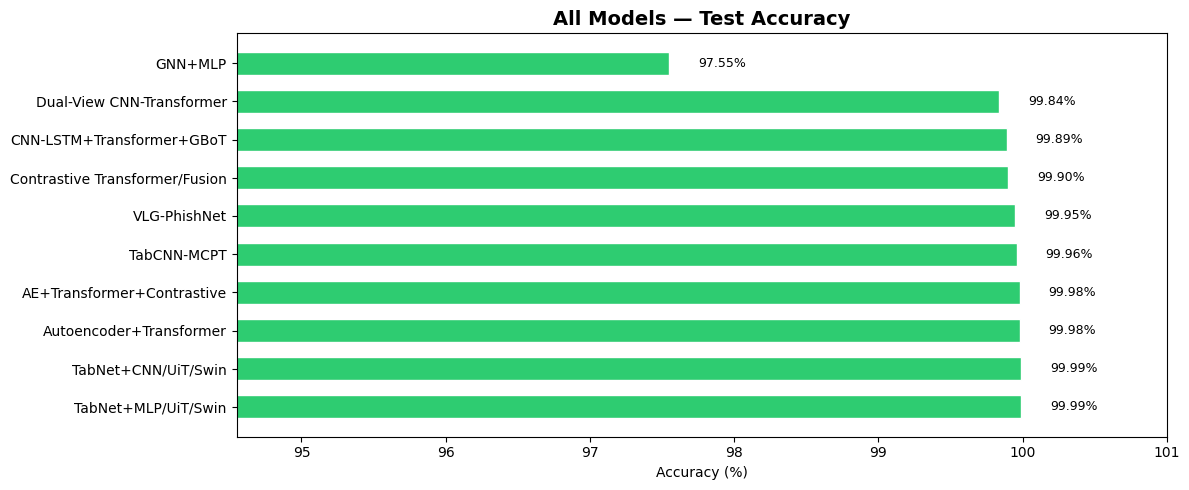


🏆 Best Model: TabNet+MLP/UiT/Swin (99.99%)


In [15]:
# ============================================================
# FINAL COMPARISON
# ============================================================
print('\n' + '='*55)
print('     📊 PHISHING DETECTION — MODEL COMPARISON')
print('='*55)
sorted_r = sorted(results.items(), key=lambda x: x[1], reverse=True)
for rank, (name, acc) in enumerate(sorted_r, 1):
    bar = '█' * int(acc/2 - 45)
    print(f'{rank:2}. {name:<38} {acc:6.2f}%  {bar}')
print('='*55)

# Bar chart
names = [x[0] for x in sorted_r]
accs  = [x[1] for x in sorted_r]
colors = ['#2ecc71' if a >= 97 else '#3498db' if a >= 95 else '#e67e22' for a in accs]

plt.figure(figsize=(12, 5))
bars = plt.barh(names, accs, color=colors, edgecolor='white', height=0.6)
plt.xlim(min(accs)-3, 101)
for bar, acc in zip(bars, accs):
    plt.text(bar.get_width()+0.2, bar.get_y()+bar.get_height()/2,
             f'{acc:.2f}%', va='center', fontsize=9)
plt.title('All Models — Test Accuracy', fontsize=14, fontweight='bold')
plt.xlabel('Accuracy (%)')
plt.tight_layout()
plt.show()
print('\n🏆 Best Model:', sorted_r[0][0], f'({sorted_r[0][1]:.2f}%)')